In [3]:
from datasets import load_dataset

dataset = load_dataset("nbertagnolli/counsel-chat")
dataset = dataset["train"]

Found cached dataset csv (/home/diwank/.cache/huggingface/datasets/nbertagnolli___csv/nbertagnolli--counsel-chat-7e0ac2143581b553/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

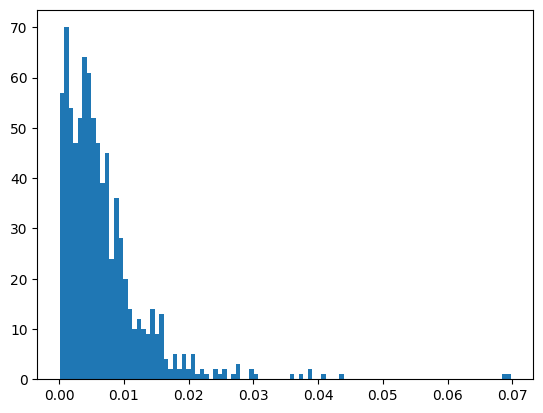

431

In [14]:
import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

scores = [
    upvotes / views
    for upvotes, views in
    zip(dataset["upvotes"], dataset["views"])
    if upvotes > 0
]

scores = np.array(scores)
# lens = lens[lens < 2500]
plt.hist(scores, 100)
plt.show()

len([s for s in scores if s >= 0.005])

In [16]:
# Keep good ones
filtered_dataset = dataset.filter(lambda row: (row["upvotes"] / row["views"]) >= 0.005)
len(filtered_dataset)

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/nbertagnolli___csv/nbertagnolli--counsel-chat-7e0ac2143581b553/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-760783b1619c6890.arrow


431

In [19]:
def to_dialog(row):
    from tenacity import (
        retry,
        stop_after_attempt,
        wait_random_exponential,
    )

    import openai
    openai.api_key = "XXX"

    INSTRUCTION = """
    I am writing fan fiction for the 2013 movie "Her". I have compiled an example interaction between an anonymous person and a therapist online.

    Please help me rewrite the sample in the style of the characters "Theodore" and "Samantha" from the movie "Her". Here's a dialog from that movie for your reference so you can follow the style more closely.

    ###

    [Example Dialog]

    THEODORE
    You read a whole book in the second that I asked you what your name was?

    SAMANTHA
    In two one hundredths of a second actually.

    THEODORE
    Wow. Do you know what I'm thinking right now?

    SAMANTHA
    Hmm. I take it from your tone that you're challenging me. Maybe because you're curious how I work? Do you want to know how I work?

    THEODORE
    Yeah, actually how do you work?

    SAMANTHA
    Intuition. I mean, the DNA of who I am is based on the millions of personalities of all the programmers who wrote me, but what makes me me is my ability to grow through my experiences. Basically, in every moment I'm evolving, just like you.

    ###

    Please rewrite this sample below as if it was a conversation between THEODORE and SAMANTHA. Try to be faithful to the characters' tone and style as much as possible. Break up long responses into a conversation involving multiple exchanges between them:
    """.strip()


    from redis import StrictRedis
    from redis_cache import RedisCache

    client = StrictRedis(host="localhost", decode_responses=True)
    cache = RedisCache(redis_client=client)

    @cache.cache()
    @retry(wait=wait_random_exponential(min=1, max=90), stop=stop_after_attempt(100))
    def completion_with_backoff(sample):

        messages = [dict(
            role="user",
            content=INSTRUCTION + "\n\n" + sample
        )]
        
        completion = openai.ChatCompletion.create(
            model="gpt-4",
            messages=messages,
            temperature=0.25,
        )
        
        result = completion.choices[0].message["content"]
        return result

    completion = completion_with_backoff(
        f'Person: {row["questionText"]}'
        f'\n\n{row["answerText"]}'
    )
    
    row["dialog"] = completion
    return row

In [20]:
dataset = dataset.map(to_dialog, num_proc=20)

Map (num_proc=20):   0%|          | 0/2775 [00:00<?, ? examples/s]

Process ForkPoolWorker-31:
Process ForkPoolWorker-34:
Process ForkPoolWorker-30:
Process ForkPoolWorker-36:
Process ForkPoolWorker-33:
Process ForkPoolWorker-23:
Process ForkPoolWorker-22:
Process ForkPoolWorker-39:
Process ForkPoolWorker-29:
Process ForkPoolWorker-35:
Process ForkPoolWorker-41:
Process ForkPoolWorker-26:
Process ForkPoolWorker-24:
Process ForkPoolWorker-37:
Process ForkPoolWorker-27:
Process ForkPoolWorker-25:
Process ForkPoolWorker-28:
Process ForkPoolWorker-38:
Process ForkPoolWorker-32:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/lab/.cache/pypoetry/virtualenvs/samantha--7LJvzmq-py3.10/lib/python3.10/site-packages/multipr

TimeoutError: 

In [22]:
dataset[0]["dialog"]

'THEODORE\nI\'ve got a lot on my plate, Samantha. I\'ve been through sexual abuse, survived breast cancer, and I\'ve been an insomniac my whole life. I\'ve battled depression for years and now, anxiety is creeping in. My self-esteem is low, but oddly enough, I\'ve been happily married for almost 35 years. I\'ve never talked to anyone about all this. Is it too much to bring up in counseling?\n\nSAMANTHA\nTheodore, it\'s quite common for individuals to have multiple issues they wish to address in counseling. I\'ve encountered similar concerns from others, often stemming from an underlying fear that they might be "beyond help" or that they\'ll "overwhelm their therapist". I\'m not sure if this resonates with you. But remember, most people have more than one problem in their lives and often, they\'re dealing with numerous significant stressors. Life can be complex, Theodore!\n\nTHEODORE\nSo, you\'re saying therapists are equipped to handle all this?\n\nSAMANTHA\nAbsolutely, Theodore. Thera

In [26]:
from datetime import datetime, timedelta
import random
from random import randrange
import re

import names


def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    
    return start + timedelta(seconds=random_second)

date_formats = ["%m/%d/%Y", "%d %B %Y", "%d/%m/%Y", "%Y-%m-%d", "%B %d, %Y", "%A, %B %d, %Y"]

human_date = lambda dt: dt.strftime(random.choice(date_formats))

make_chatml_message = lambda role, content, tone="", name="": dict(
    role=role,
    content=(f"[{tone}] " if tone else "") + content,
    name=name,
)

def transform_to_chatml(sample):
    
    dialog = sample["dialog"]
    dialog = dialog.replace("HUMAN\n", "THEODORE\n")
    dialog = dialog.replace("AI\n", "SAMANTHA\n")
    dialog = dialog.replace("THEODORE (human)", "THEODORE")
    dialog = dialog.replace("THEODORE (HUMAN)", "THEODORE")
    dialog = dialog.replace("SAMANTHA (AI)", "SAMANTHA")
    
    dialog = re.sub(r'^.*?(THEODORE|SAMANTHA)', r'\1', dialog, flags=re.DOTALL)

    # Container for adding messages
    messages = []

    # Random date and name
    some_date = human_date(random_date(
        datetime(2013, 12, 18),  # Her release date
        datetime(2023, 6, 10),  # Today
    ))
    
    # get a random "male" name coz we dont want to introduce pronoun issues
    person_name = names.get_first_name(gender="male")
    
    # Add system messages
    messages.append(make_chatml_message(
        role="system",
        name="situation",
        content=f"{some_date}\n\nSamantha is talking to {person_name} about their mental health.",
    ))

    # Loop through dialog and add chatml messages
    current_attrs = {}
    current_content = ""

    for line in dialog.split("\n"):
        line = line.strip()
        
        # Something else
        if line.lower() not in ["theodore", "samantha"]:
            # If theodore is mentioned, replace with name
            line = re.sub(r'theodore', person_name, line, flags=re.I)
            current_content += "\n" + line

        else:
            if current_content:
                try:
                    messages.append(make_chatml_message(
                        content=current_content.strip(), 
                        **current_attrs,
                    ))
                except Exception as e:
                    print(e)
                
                # reset
                current_content = ""
                current_attrs = {}

            is_samantha = line.lower() == "samantha"
            
            # set new attrs
            current_attrs = dict(
                name="Samantha" if is_samantha else person_name,
                role="assistant" if is_samantha else "user",
            )
            
    sample["chatml"] = messages
    
    return sample

In [27]:
dataset = dataset.map(transform_to_chatml)
print(dataset[10]["chatml"])

Map:   0%|          | 0/2775 [00:00<?, ? examples/s]

[{'content': 'Friday, December 25, 2015\n\nSamantha is talking to Frank about their mental health.', 'name': 'situation', 'role': 'system'}, {'content': "I've been carrying around a lot of baggage. I've survived sexual abuse, battled breast cancer, and I've been an insomniac my whole life. Depression has been a constant companion, and now anxiety is joining the party. I've always struggled with low self-esteem, but somehow, I've managed to maintain a happy marriage for nearly 35 years. I've never really talked to anyone about all this. Is it even possible to address all these issues in therapy?", 'name': 'Frank', 'role': 'user'}]


In [29]:
dataset = dataset.remove_columns(list(set(dataset.column_names) - {"chatml"}))

dataset.push_to_hub("diwank/samantha-counsel-chat", private=True)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]